# Find failed patches and rerun

Following the first run a number of coadds failed and subsequent photo-pipe stages. I think the majority of these were Memory errors for the coaddition. Some of the photopipe runs timed out.

In [1]:
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
#We are using a rings skymap
from lsst.geom import SpherePoint 
from lsst.geom import degrees
from lsst.skymap.ringsSkyMap import RingsSkyMap, RingsSkyMapConfig

config = RingsSkyMapConfig()
#These config options are chose to be the same as HSC:
#https://github.com/lsst/obs_subaru/blob/master/config/hsc/makeSkyMap.py
#and copied for obs_vista
#https://github.com/lsst-uk/obs_vista/blob/master/config/makeSkyMap.py
config.numRings = 120
config.projection = "TAN"
config.tractOverlap = 1.0/60 # Overlap between tracts (degrees)
config.pixelScale = 0.168
sm = RingsSkyMap(config)
sxds_tracts = [8282,8283,8284,8523,8524,8525,8765,8766,8767] #manually got these from HSC DR2 pages

In [2]:
SUFFIX=time.strftime("%Y%m%d")
WORK_DIR = '/home/ir-shir1/rds/rds-iris-ip005/ras81/lsst-ir-fusion/dmu4/dmu4_SXDS'
MAKE_INDIVIDUAL_SLURM=True
SLURM_DIR = 'slurm_failed_tiles_rerun_{}'.format(SUFFIX)
print(SUFFIX)

20210122


In [3]:
coadd_template = open('../templates/coadd_template.sh', 'r').read()
photo_template = open('../templates/photo_template.sh', 'r').read()
slurm_template = open('../templates/slurm_template.slurm', 'r').read()
slurm_array_template = open('../templates/slurm_array_template.slurm', 'r').read()

## 1. Plot failed patches

In [4]:
#USE HSC-Y which is the last task run in the pipeline
#forced = glob.glob('./data/rerun/coaddForcedPhot/deepCoadd-results/HSC-Y/*/*/*.fits)
f = open('complete_forces_VISTA-Ks_20201112.lis', "r")
forced = [l for l in f]
#coadds
f_old = open('coadds_VISTA-Ks_20201102.lis', "r")
f_new = open('coadd_VISTA-Ks_20201109.lis', "r")
coadds_old = [l for l in f_old]
#coadds = glob.glob('./data/rerun/coadd/deepCoadd-results/VISTA-Ks/*/*/*.fits)
coadds = [l for l in f_new]

In [5]:
coadds[-1]

'data/rerun/coadd/deepCoadd/VISTA-Ks/8767/8,3.fits\n'

In [6]:
len(coadds), len(coadds_old)

(205, 169)

In [7]:
len(forced)

140

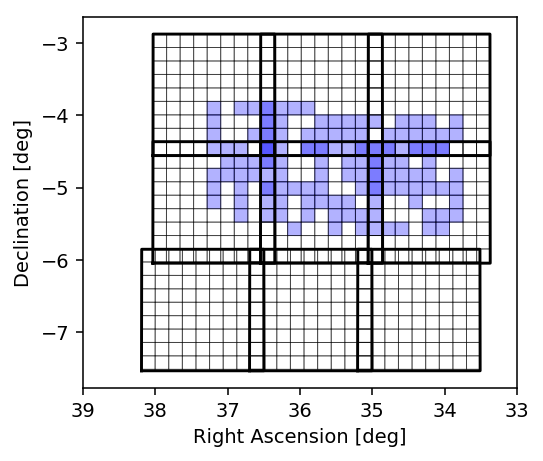

In [8]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=140)
        
for tract in sxds_tracts:
    vertices = sm.generateTract(tract).getVertexList()
    ra = [vertices[n][0].asDegrees() for n in np.mod(np.arange(5),4)]
    dec = [vertices[n][1].asDegrees() for n in np.mod(np.arange(5),4)]
    ax.plot(ra, dec, c = 'k')
    for p in np.nditer(np.meshgrid(np.arange(0,9), np.arange(0,9))):
        #print(p[0], p[1])
        t = sm.generateTract(tract)
        vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
        ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
        #print(tract, ra)
        dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
        ax.plot(ra, dec, c = 'k', alpha=0.5, linewidth=0.5)

for file in coadds:
    patch = file.split('/')[6].split('.')[0]
    p = [int(i) for i in patch.split(',')]
    tract = int(file.split('/')[5])
    
    t = sm.generateTract(tract)
    vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
    ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
    #print(tract, ra)
    dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
    #ax.fill(ra, dec, c = 'r', alpha=0.3, linewidth=0.5)


for file in forced:
    patch = file.split('/')[6]
    p = [int(i) for i in patch.split(',')]
    tract = int(file.split('/')[5])
    
    t = sm.generateTract(int(tract))
    vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
    ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
    #print(tract, ra)
    dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
    ax.fill(ra, dec, c = 'b', alpha=.3, linewidth=0.5)
        

    
ax.axis('scaled')
ax.set_xlim([39, 33])
ax.set_xlabel('Right Ascension [deg]')
ax.set_ylabel('Declination [deg]')
fig.savefig('./figs/sxds_failed_patches.pdf', overwrite=True)
fig.savefig('./figs/sxds_failed_patches.png', overwrite=True)

In [9]:
patches_in_video = json.loads(open('patches_in_video.json', 'r').read())

In [10]:
patches_in_video

{'8766': [[4, 0],
  [7, 2],
  [4, 2],
  [8, 2],
  [5, 1],
  [3, 2],
  [3, 3],
  [2, 1],
  [3, 0],
  [1, 1],
  [5, 2],
  [6, 0],
  [6, 2],
  [2, 0],
  [8, 0],
  [8, 1],
  [1, 2],
  [0, 3],
  [1, 0],
  [6, 1],
  [7, 0],
  [0, 1],
  [2, 3],
  [3, 1],
  [7, 1],
  [2, 2],
  [0, 0],
  [4, 1],
  [1, 3],
  [5, 0],
  [0, 2]],
 '8524': [[0, 8],
  [4, 3],
  [7, 4],
  [5, 4],
  [8, 8],
  [6, 8],
  [7, 8],
  [5, 6],
  [1, 2],
  [0, 3],
  [8, 4],
  [4, 8],
  [5, 3],
  [2, 3],
  [2, 2],
  [6, 3],
  [3, 5],
  [7, 7],
  [4, 2],
  [0, 5],
  [3, 2],
  [1, 7],
  [5, 2],
  [6, 6],
  [1, 8],
  [8, 3],
  [0, 6],
  [7, 3],
  [8, 5],
  [3, 6],
  [0, 2],
  [4, 5],
  [6, 5],
  [4, 6],
  [1, 4],
  [4, 4],
  [6, 7],
  [6, 4],
  [5, 8],
  [1, 6],
  [3, 7],
  [3, 8],
  [1, 3],
  [2, 6],
  [7, 2],
  [2, 5],
  [7, 5],
  [8, 2],
  [2, 4],
  [7, 6],
  [5, 5],
  [4, 7],
  [3, 3],
  [0, 4],
  [8, 7],
  [0, 7],
  [6, 2],
  [5, 7],
  [2, 7],
  [8, 6],
  [2, 8],
  [3, 4],
  [1, 5]],
 '8765': [[4, 0],
  [5, 1],
  [2, 1],
  [1

In [11]:
str([1,2])

'[1, 2]'

In [12]:
passed_coadds = {}

for file in coadds:
    patch = file.split('/')[6].split('.')[0]
    p = [int(i) for i in patch.split(',')]
    #print(str(p))
    tract = int(file.split('/')[5])
    try:
        passed_coadds[tract] = passed_coadds[tract].union(set([str(p)]))
    except KeyError:
        passed_coadds[tract] = set([str(p)])

In [13]:
failed_tiles = {}
for tract in patches_in_video:
    failed_tiles[tract] = set([str(p) for p in patches_in_video[tract]]).difference(passed_coadds[int(tract)])
  

In [14]:
failed_tiles

{'8766': {'[2, 2]'},
 '8524': {'[0, 2]', '[1, 2]', '[2, 4]'},
 '8765': set(),
 '8523': {'[2, 8]', '[3, 3]'},
 '8767': {'[6, 1]'},
 '8525': {'[4, 2]',
  '[5, 2]',
  '[6, 2]',
  '[6, 8]',
  '[7, 2]',
  '[8, 2]',
  '[8, 6]'}}

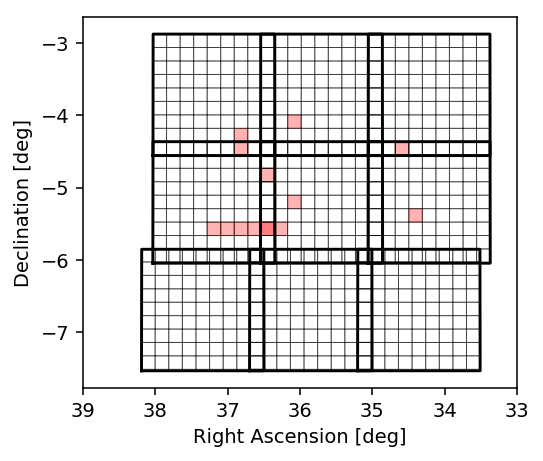

In [15]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=140)
        
for tract in sxds_tracts:
    vertices = sm.generateTract(tract).getVertexList()
    ra = [vertices[n][0].asDegrees() for n in np.mod(np.arange(5),4)]
    dec = [vertices[n][1].asDegrees() for n in np.mod(np.arange(5),4)]
    ax.plot(ra, dec, c = 'k')
    for p in np.nditer(np.meshgrid(np.arange(0,9), np.arange(0,9))):
        #print(p[0], p[1])
        t = sm.generateTract(tract)
        vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
        ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
        #print(tract, ra)
        dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
        ax.plot(ra, dec, c = 'k', alpha=0.5, linewidth=0.5)

for tract in failed_tiles:
    for patch in failed_tiles[tract]:
        
        p = [int(patch[1]), int(patch[4])]
        tract = int(tract)
    
        t = sm.generateTract(tract)
        vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
        ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
        #print(tract, ra)
        dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
        ax.fill(ra, dec, c = 'r', alpha=0.3, linewidth=0.5)



        

    
ax.axis('scaled')
ax.set_xlim([39, 33])
ax.set_xlabel('Right Ascension [deg]')
ax.set_ylabel('Declination [deg]')
fig.savefig('./figs/sxds_patches_to_rerun_{}.pdf'.format(SUFFIX), overwrite=True)
fig.savefig('./figs/sxds_patches_to_rerun_{}.png'.format(SUFFIX), overwrite=True)

The row at the bottom right have very little of the VISTA tile overlapping so lets remove them manually

In [16]:
#patches on row 2 in tracts 8524 and 8525 are barely covered
after_manual_removals = {
 '8766': {'[2, 2]'},
 '8524': {
 #'[0, 2]', 
 #'[1, 2]', 
 '[2, 4]'},
 '8765': set(),
 '8523': {'[2, 8]', '[3, 3]'},
 '8767': {'[6, 1]'},
 '8525': {
  #'[4, 2]',
  #'[5, 2]',
  #'[6, 2]',
  '[6, 8]',
  #'[7, 2]',
  #'[8, 2]',
  '[8, 6]'}
}

In [17]:
failed_tiles = after_manual_removals

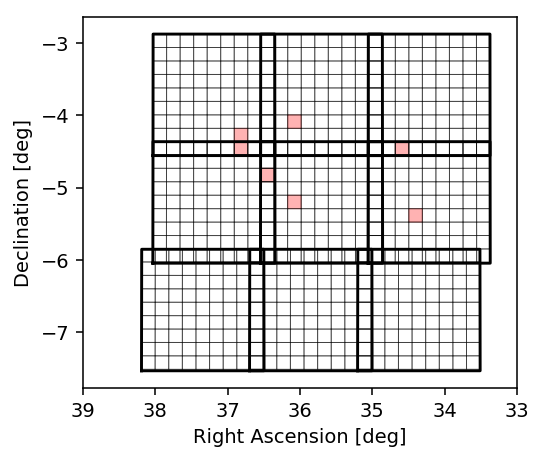

In [18]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=140)
        
for tract in sxds_tracts:
    vertices = sm.generateTract(tract).getVertexList()
    ra = [vertices[n][0].asDegrees() for n in np.mod(np.arange(5),4)]
    dec = [vertices[n][1].asDegrees() for n in np.mod(np.arange(5),4)]
    ax.plot(ra, dec, c = 'k')
    for p in np.nditer(np.meshgrid(np.arange(0,9), np.arange(0,9))):
        #print(p[0], p[1])
        t = sm.generateTract(tract)
        vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
        ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
        #print(tract, ra)
        dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
        ax.plot(ra, dec, c = 'k', alpha=0.5, linewidth=0.5)

for tract in failed_tiles:
    for patch in failed_tiles[tract]:
        
        p = [int(patch[1]), int(patch[4])]
        tract = int(tract)
    
        t = sm.generateTract(tract)
        vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
        ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
        #print(tract, ra)
        dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
        ax.fill(ra, dec, c = 'r', alpha=0.3, linewidth=0.5)



        

    
ax.axis('scaled')
ax.set_xlim([39, 33])
ax.set_xlabel('Right Ascension [deg]')
ax.set_ylabel('Declination [deg]')
fig.savefig('./figs/sxds_patches_to_rerun_{}.pdf'.format(SUFFIX), overwrite=True)
fig.savefig('./figs/sxds_patches_to_rerun_{}.png'.format(SUFFIX), overwrite=True)

## 2 Make job files

Presently we just make a single lists of failures to have both coadd and photopipe rerun

In [19]:
try:
    os.mkdir(SLURM_DIR)
except FileExistsError:
    print("{} already exists.".format(SLURM_DIR))

In [20]:
n = 0
numCPUs = 15 # These failed with a memory error with 5
for tract in failed_tiles:
    for patch in failed_tiles[tract]:
        patch = '{},{}'.format(patch[1], patch[4])
        print("coadd_rerun_{tract}_{patch}_{n}.sh".format(
            tract = tract, patch=patch, n=n
        ))
        
        job_name = "coadd_{}_{}_{}".format(tract, patch, n)
  
        f_sh = open("./{}/{}.sh".format(SLURM_DIR,job_name), "w+")
        f_sh.write(coadd_template.format(tract=tract, patch=patch,  numCPUs=numCPUs))
        f_sh.close()
        if MAKE_INDIVIDUAL_SLURM:
            f_slurm = open("./{}/{}.slurm".format(SLURM_DIR,job_name), "w+")
            f_slurm.write(slurm_template.format(
                job_name=job_name,
                hours='36',
                sh_name="{}/{}/{}.sh".format(WORK_DIR,SLURM_DIR,job_name),
                cpus_per_task=numCPUs,
                himem='-himem'
            ))
            f_slurm.close()
        n+=1

coadd_rerun_8766_2,2_0.sh
coadd_rerun_8524_2,4_1.sh
coadd_rerun_8523_3,3_2.sh
coadd_rerun_8523_2,8_3.sh
coadd_rerun_8767_6,1_4.sh
coadd_rerun_8525_6,8_5.sh
coadd_rerun_8525_8,6_6.sh


In [21]:
#make one slurm job for all sh scripts
start=0
stop =n-1
jobNameBase='coadd'
job_name = jobNameBase + '_array_all_{}-{}'.format(start, stop)
slurm_filename = "./{}/{}.slurm".format(SLURM_DIR,job_name)
array_slurm = open(slurm_filename, "w+")
array_slurm.write(slurm_array_template.format(
    job_name=job_name,
    hours='36',
    start=start,
    stop=stop,
    WORK_DIR="{}/{}".format(WORK_DIR,SLURM_DIR),
    jobNameBase=jobNameBase,
    cpus_per_task=numCPUs,
    himem='-himem'
))
array_slurm.close()
print(slurm_filename)

./slurm_failed_tiles_rerun_20210122/coadd_array_all_0-6.slurm


## 3. Make photo pipe Slurm files

In [22]:
n = 0
numCPUs = 10 # These failed with a memory error with 5
for tract in failed_tiles:
    for patch in failed_tiles[tract]:
        patch = '{},{}'.format(patch[1], patch[4])
        print("phot_rerun_{tract}_{patch}_{n}.sh".format(
            tract = tract, patch=patch, n=n
        ))
        
        job_name = "phot_{}_{}_{}".format(tract, patch, n)
  
        f_sh = open("./{}/{}.sh".format(SLURM_DIR,job_name), "w+")
        f_sh.write(photo_template.format(tract=tract, patch=patch))
        f_sh.close()
        if MAKE_INDIVIDUAL_SLURM:
            f_slurm = open("./{}/{}.slurm".format(SLURM_DIR,job_name), "w+")
            f_slurm.write(slurm_template.format(
                job_name=job_name,
                hours='36',
                sh_name="{}/{}/{}.sh".format(WORK_DIR,SLURM_DIR,job_name),
                cpus_per_task='1',
                himem=''
            ))
            f_slurm.close()
        n+=1

phot_rerun_8766_2,2_0.sh
phot_rerun_8524_2,4_1.sh
phot_rerun_8523_3,3_2.sh
phot_rerun_8523_2,8_3.sh
phot_rerun_8767_6,1_4.sh
phot_rerun_8525_6,8_5.sh
phot_rerun_8525_8,6_6.sh
